# Begin Imports

In [1]:
!pip install sklearn --upgrade 

In [2]:
import sklearn
sklearn.__version__

'1.1.3'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
from sklearn import set_config

In [4]:
import joblib
loaded = joblib.load('reg_l01.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'Linear Regression', 'Decision Tree'])

# Begin Preprocessing

In [5]:
X_train = loaded['X_train']
y_train = loaded['y_train']
X_test = loaded['X_test']
y_test = loaded['y_test']
linreg_model = loaded['Linear Regression']
dec_model = loaded['Decision Tree']

In [6]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [7]:
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

In [8]:
numeric_pipe = make_pipeline(mean_imputer)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [9]:
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [10]:
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

preprocessor = make_column_transformer(number_tuple, category_tuple, verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000258E061A790>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000258E334CB80>)],
                  verbose_feature_names_out=False)

In [11]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000258E061A790>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000258E334CB80>)],
                  verbose_feature_names_out=False)

In [12]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed= preprocessor.transform(X_test)

In [13]:
X_train_processed = pd.DataFrame(preprocessor.transform(X_train),columns= preprocessor.get_feature_names_out())
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,16.350,0.029565,256.4646,2009.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,15.250,0.000000,179.7660,2009.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,12.350,0.158716,157.2946,1999.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,7.975,0.014628,82.3250,2004.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,19.350,0.016645,120.9098,2002.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
X_test_processed = pd.DataFrame(preprocessor.transform(X_test),columns= preprocessor.get_feature_names_out())
X_test_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,14.300000,0.026300,79.4302,1987.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,7.930000,0.071136,42.7086,1997.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.500000,0.041313,42.0454,1999.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,12.904458,0.044767,173.7054,1985.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,10.195000,0.012456,197.5110,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [15]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [16]:
preprocessor.get_feature_names_out()

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Si

In [17]:
X_train_processed.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High

In [18]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = preprocessor.get_feature_names_out()
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [19]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax


In [20]:
## Fitting and evaluating the model
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)
evaluate_regression(lin_reg, X_train_processed, y_train, X_test_processed, y_test)

Split,R^2,MAE,RMSE
Train,0.56,847.15,"1,138.95"
Test,0.57,804.20,"1,093.02"


# Model 1 Linear Regression

In [21]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

# Extracting and Visualizing Coefficients

In [22]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [23]:
X_train_processed.iloc[0]

Item_Weight                          16.350000
Item_Visibility                       0.029565
Item_MRP                            256.464600
Outlet_Establishment_Year          2009.000000
Item_Fat_Content_LF                   0.000000
Item_Fat_Content_Low Fat              1.000000
Item_Fat_Content_Regular              0.000000
Item_Fat_Content_low fat              0.000000
Item_Fat_Content_reg                  0.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      0.000000
Item_Type_Dairy                       0.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   1.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Sea

In [24]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                           -2.018351
Item_Visibility                     -422.374939
Item_MRP                              15.715542
Outlet_Establishment_Year            -19.650740
Item_Fat_Content_LF                  -64.334853
Item_Fat_Content_Low Fat              -4.863129
Item_Fat_Content_Regular              59.519729
Item_Fat_Content_low fat              57.277190
Item_Fat_Content_reg                 -47.598937
Item_Type_Baking Goods               -19.483134
Item_Type_Breads                     -47.924135
Item_Type_Breakfast                   26.983524
Item_Type_Canned                       8.079370
Item_Type_Dairy                     -126.659331
Item_Type_Frozen Foods               -19.880444
Item_Type_Fruits and Vegetables       27.193595
Item_Type_Hard Drinks                 -6.801301
Item_Type_Health and Hygiene           8.264246
Item_Type_Household                  -12.978862
Item_Type_Meat                       -31.537346
Item_Type_Others                     -43

In [25]:
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [26]:
coeffs.sort_values()

Outlet_Type_Grocery Store         -1,104.3214
Outlet_Identifier_OUT010            -629.3265
Outlet_Identifier_OUT019            -474.9949
Item_Visibility                     -422.3749
Outlet_Identifier_OUT045            -189.8446
Outlet_Location_Type_Tier 1         -141.9865
Item_Type_Dairy                     -126.6593
Outlet_Size_High                     -82.7554
Outlet_Identifier_OUT013             -82.7554
Item_Fat_Content_LF                  -64.3349
Item_Type_Soft Drinks                -57.9261
Outlet_Size_Small                    -53.9247
Item_Type_Breads                     -47.9241
Item_Fat_Content_reg                 -47.5989
Item_Type_Others                     -43.4801
Item_Type_Snack Foods                -40.9085
Item_Type_Meat                       -31.5373
Item_Type_Frozen Foods               -19.8804
Outlet_Establishment_Year            -19.6507
Item_Type_Baking Goods               -19.4831
Item_Type_Household                  -12.9789
Item_Type_Hard Drinks             

AttributeError: 'tuple' object has no attribute 'axvline'

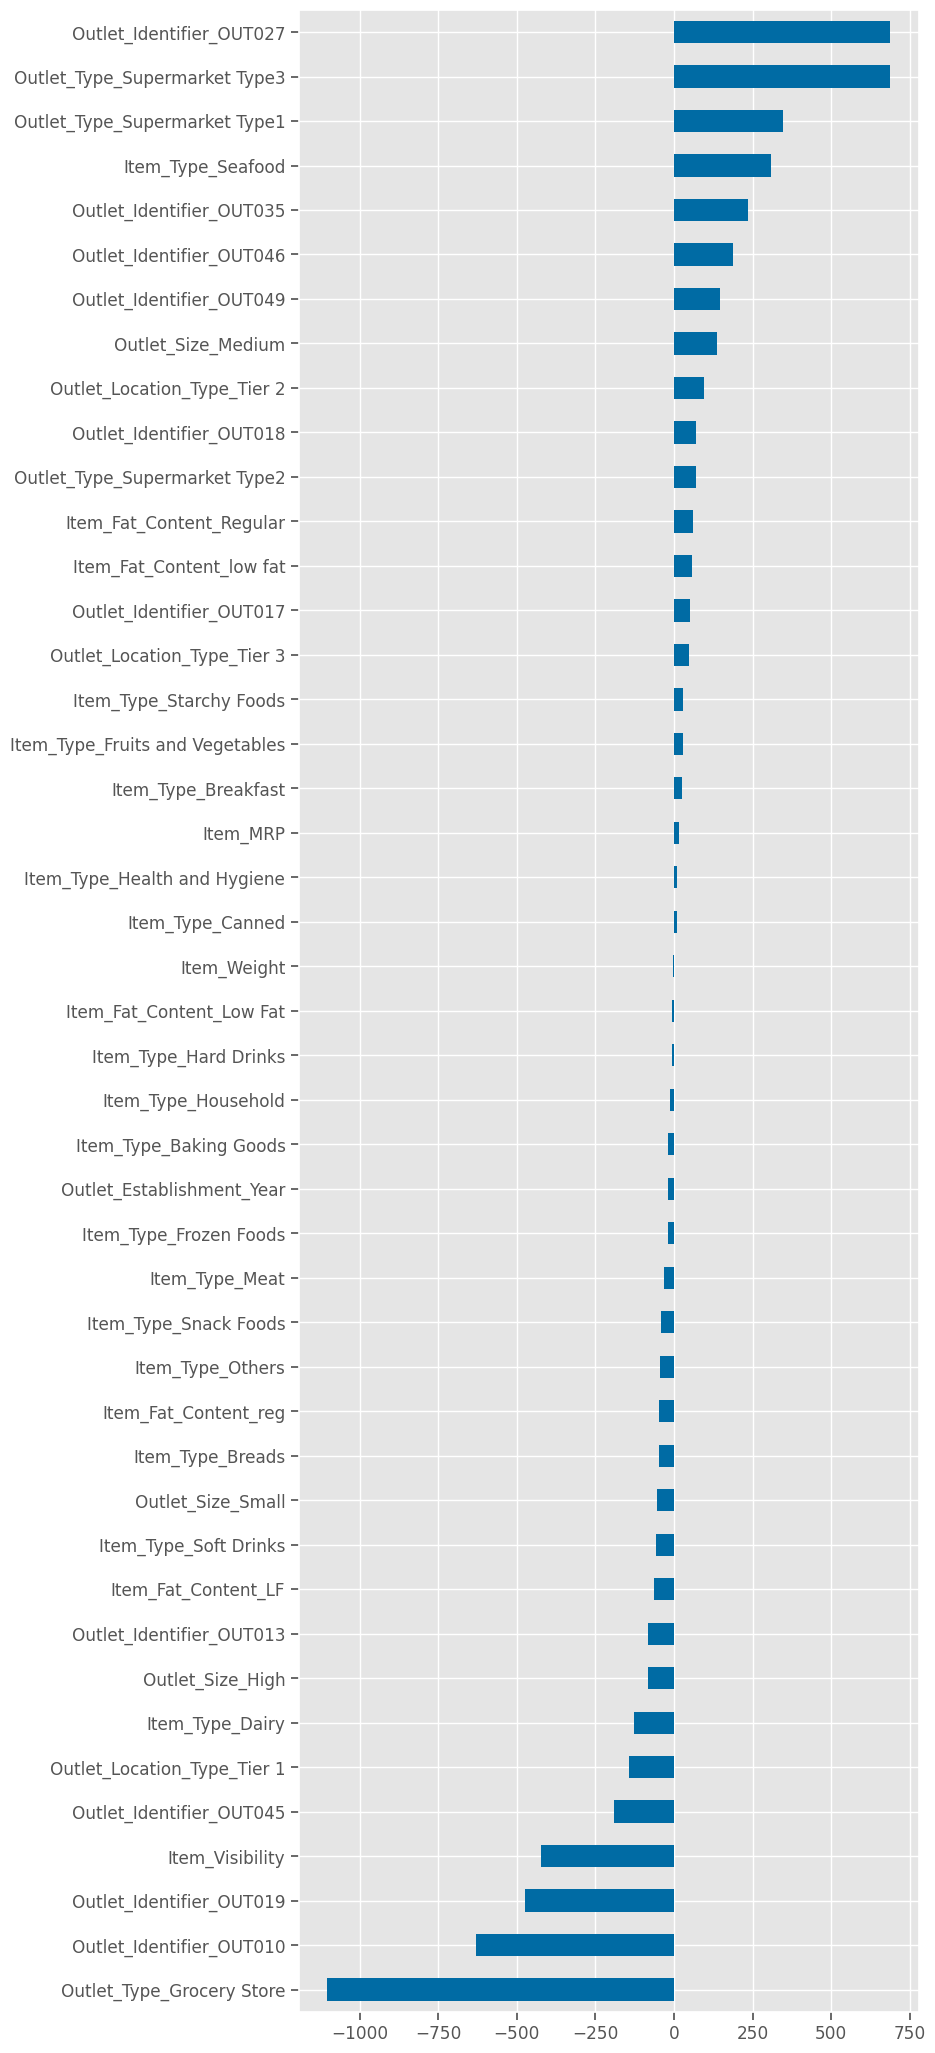

In [28]:
ax = plt.subplots()
x = coeffs.drop("intercept").sort_values().plot(kind='barh', figsize=(8,26))
ax.axvline(0, color='k')
ax.set(xlabel='Sales', title="Coefficients - Supermarkets");

# Top three Coefficients

Outlet_Type_Grocery Store         -1,104.3214

Outlet_Identifier_OUT010            -629.3265

Outlet_Identifier_OUT027             688.1500

For the Outlet_Type_Grocery Store, every food sold, there will be a negative 1,104  on it. 

For the Outlet_Identifier_OUT010, every sample sold, there will be a negative 629 on it.

For the Outlet_Identifier_OUT027, every sample sold, there will be a positive 688 on it.


# Model 2 Decision Tree Regressor

In [29]:
dec_model.fit(X_train_processed, y_train)

DecisionTreeRegressor(max_depth=11, random_state=42)

Split,R^2,MAE,RMSE
Train,0.70,616.61,935.56
Test,0.52,799.95,"1,154.97"


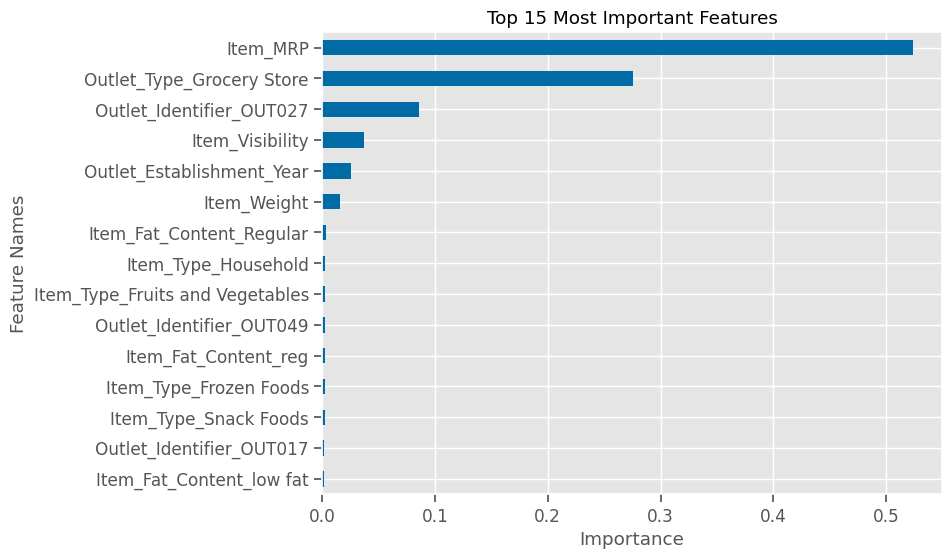

In [30]:
evaluate_regression(dec_model,X_train_processed, y_train, X_test_processed,y_test)
loaded_importances = get_importances(dec_model)
plot_importance_color(loaded_importances,top_n=15,color_dict=None);

- Top 5 Features 
1. Item_MRP
2. Outlet_Type_Grocery Store
3. Outlet_Identifier_OUT027
4. Item_Visibility
5. Outlet_Establishment_Year
